In [1]:
# PURPOSE: simulate from the univariate plankton model
# Illustrate: 
# - discretization and numerical solution (and built-in ODE solvers) 
# - adding stichasticity (additive white noise, stochastic parameters)
# - realization and ensembles for time series models 

rm(list=ls())

#############
# SET UP 

set.seed(7) # set random number seed if desired 

T <- 365*4 # set duration of simulaton in days
dt <- 1 # set time step (here 1 day)
nt <- T*dt # determine model steps needed

gamma <- 0.25  # growth parameter
lambda <- 0.1 # mortality/loss parameter
om <- 2*pi/365 # annual frequency 

################

In [3]:
P=array(NA,nt) # accumulator for state vector
P[1] <- 2.5 # initial condition

 for (k in 2:nt){
    time <- k*dt
    P[k]=P[k-1]+dt*(gamma*(1+sin(om*time))*P[k-1] - lambda*P[k-1]^2);
	}

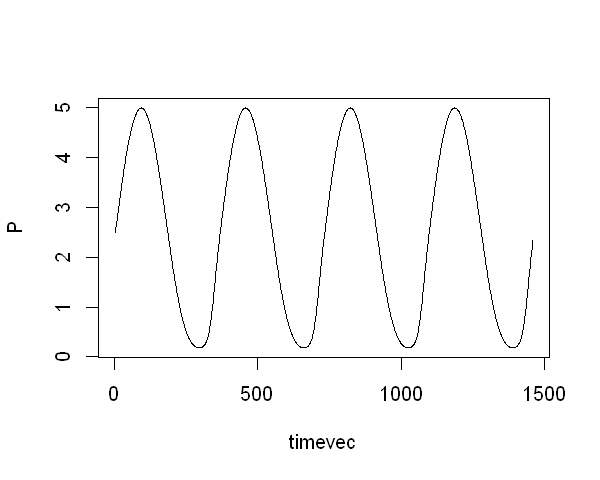

In [7]:
options(repr.plot.width=5, repr.plot.height=4)
par(mfrow=c(1,1))
timevec=seq(dt,dt*nt,dt)
plot(timevec,P,type="l")

In [8]:
library(deSolve)

# ODE solver function
Pgrowth <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    dP <- gamma*(1+sin(om*t))*P - lambda*P^2
    list(c(dP))
  })
}

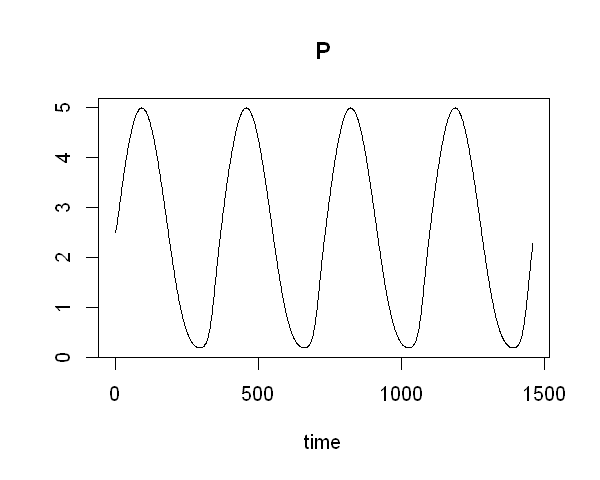

In [9]:
# implementation 
theta <- c(gamma = .25, lambda = .1) # parameters, need to be named
state <- c(P = 2.5) # intial condition
times <- seq(0, T, by = 1) # output times
# call ODE function
out <- ode(y = state, times = times, func = Pgrowth, parms = theta)
plot(out) # plot the ODE object

In [10]:
###############
# STOCHASTICITY - SINGLE REALIZATIONS

# (1) adding stochasticit using additive, signal-scaled white noise

# accumulator for state vector
P=array(NA,nt)
P[1] <- 2.5

for (k in 2:nt){
  time <- k*dt
  noise <- sqrt(dt)*0.05*P[k-1]*rnorm(1)
  P[k]=P[k-1]+dt*(gamma*(1+sin(om*time))*P[k-1] - lambda*P[k-1]^2)+ noise;
}


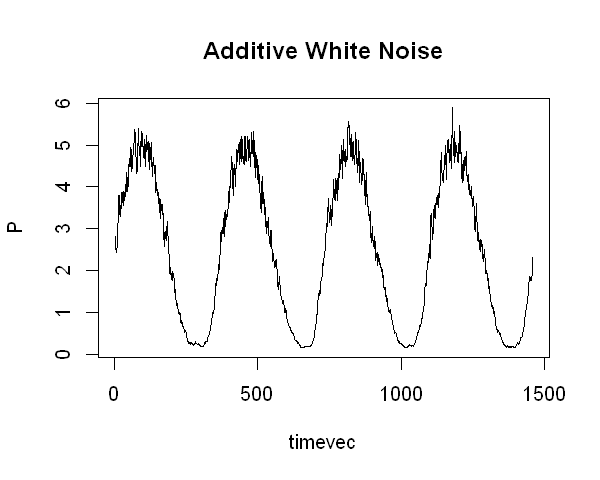

In [11]:
timevec=seq(dt,dt*nt,dt)
plot(timevec,P,type="l", main="Additive White Noise")

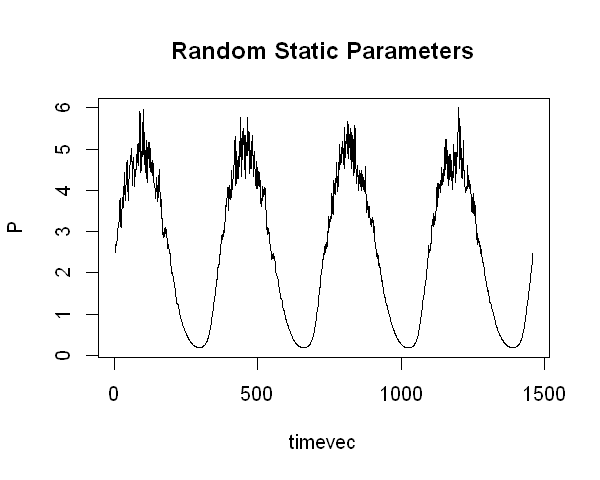

In [12]:
P=array(NA,nt)
P[1] <- 2.5

for (k in 2:nt){
  time <- k*dt
  gammas <- rlnorm(1,log(.25),0.05)
  lambdas <- runif(1,.08,0.12)
  P[k]=P[k-1]+dt*(gammas*(1+sin(om*time))*P[k-1] - lambdas*P[k-1]^2);
}

timevec=seq(dt,dt*nt,dt)
plot(timevec,P,type="l", main="Random Static Parameters")

In [14]:
# Approach 2: parameters are dynamic, follow stochastic process AR(1)

# create dynamical parameters 
nday <- 365
dgamma <- array(NA,nday)
dgamma[1] <- 0
dlambda<- array(NA,nday)
dlambda[1] <- 0

for (k in 2:nday){
dgamma[k] <- 0.9*dgamma[k-1]+0.01*rnorm(1)
dlambda[k] <- 0.95*dlambda[k-1]+0.01*rnorm(1)
}

gammat=gamma+dgamma
lambdat=lambda+dlambda

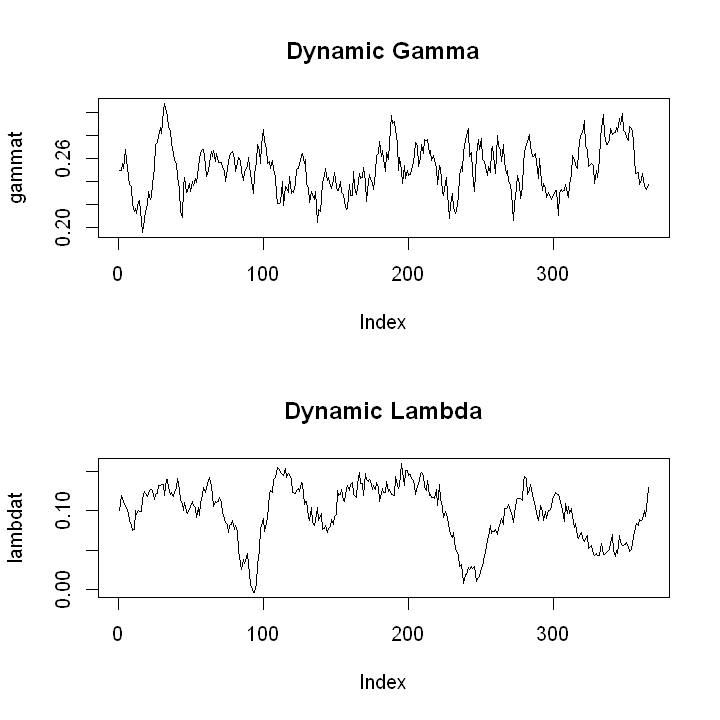

In [16]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow=c(2,1))
plot(gammat, type="l", main="Dynamic Gamma")  
plot(lambdat, type="l", main="Dynamic Lambda") 

In [17]:
# use these time-varying parameters in simulation
P=array(NA,nt)
P[1] <- 2.5
dgamma <- 0
dlambda <- 0

for (k in 2:nt){
  time <- k*dt
  dgamma <- 0.9*dgamma+0.01*rnorm(1)
  dlambda <- 0.95*dlambda+0.001*rnorm(1)  
  P[k]=P[k-1]+dt*((gamma+dgamma)*(1+sin(om*time))*P[k-1] - (lambda+dlambda)*P[k-1]^2);
}


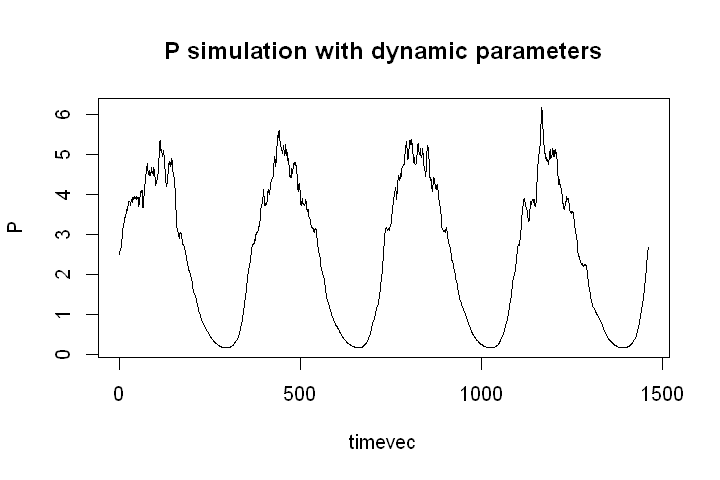

In [19]:
options(repr.plot.width=6, repr.plot.height=4)
timevec=seq(dt,dt*nt,dt)
par(mfrow=c(1,1))
plot(timevec,P,type="l", main="P simulation with dynamic parameters")

In [20]:
##### ENSEMBLES ########

###########
# Approach 1: parameters follow pdf, one parameter set per realization

nr <- 50
Pacc=array(NA,dim=c(nt,nr))

P=array(NA,nt)
P[1] <- 2.5

for (ir in 1:nr){
  gammas <- rlnorm(1,log(.25),0.2)
  lambdas <- runif(1,.05,0.15)  
    for (k in 2:nt){
      time <- k*dt
      P[k]=P[k-1]+dt*(gammas*(1+sin(om*time))*P[k-1] - lambdas*P[k-1]^2);
    }
    
    Pacc[,ir]=P
}


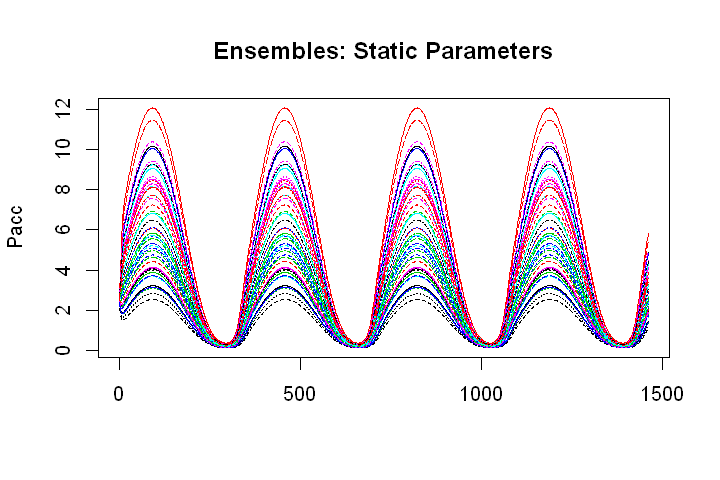

In [21]:
par(mfrow=c(1,1))  
timevec=seq(dt,dt*nt,dt)
matplot(Pacc,type="l", main="Ensembles: Static Parameters")

In [22]:
###########
# Approach 2: parameters are dynamic (AR)
# create ensembles

nr <- 100
Pacc=array(NA,dim=c(nt,nr))

P=array(NA,nt)
P[1] <- 2.5
dgamma <- 0
dlambda <- 0

for (ir in 1:nr){
  for (k in 2:nt){
    time <- k*dt
    dgamma <- 0.9*dgamma+0.01*rnorm(1)
    dlambda <- 0.95*dlambda+0.005*rnorm(1)  
    P[k]=P[k-1]+dt*((gamma+dgamma)*(1+sin(om*time))*P[k-1] - (lambda+dlambda)*P[k-1]^2);
  }
  Pacc[,ir]=P
}

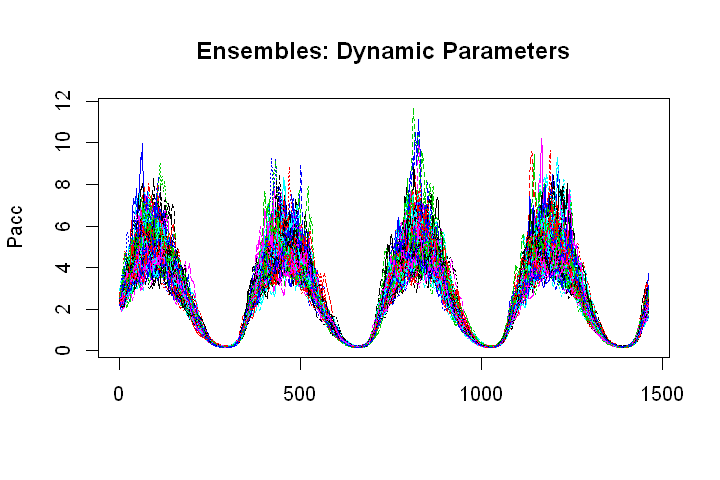

In [23]:
par(mfrow=c(1,1))
timevec=seq(dt,dt*nt,dt)
matplot(Pacc,type="l", main="Ensembles: Dynamic Parameters")

Warning message in arrows(idx, Plower[idx], idx, Pupper[idx], length = 0.05, angle = 90, :
"zero-length arrow is of indeterminate angle and so skipped"

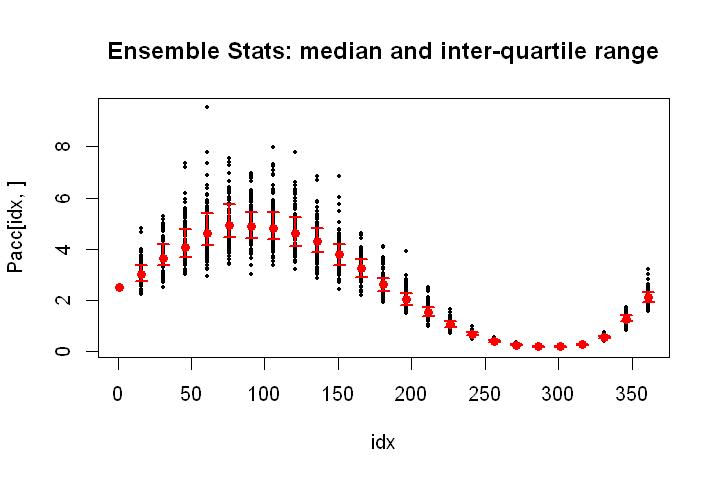

In [24]:
####################
# VISUALIZATION AND SUMMARY STATS

# statistics of samples

# medians (for each time)
Pmed <- apply(Pacc,1,median)

# quantiles 
upper <- function(x) quantile(x,.75)
Pupper <- apply(Pacc,1,upper)

lower <- function(x) quantile(x,.25)
Plower <- apply(Pacc,1,lower)

# subsample on coarser time interval (to aid in visualization)

idx <- seq(1,365,15)
matplot(idx, Pacc[idx,],type="p", pch=19, col="black", cex=0.5, main="Ensemble Stats: median and inter-quartile range")
points(idx,Pmed[idx], pch=19, cex=1, col="red")
arrows(idx, Plower[idx], idx, Pupper[idx], length=0.05, angle=90, code=3, col="red",lwd=2)
#segments(idx, Plower[idx], idx, Pupper[idx])
